# Predicting Used Car Prices

---
---

## Problem Description and Initial Data Analysis

For my predictive analytics project, I aim to develop a model that accurately predicts the prices luxury cars using machine learning techniques. The project focuses on understanding key factors influencing car pricing, utilizing advanced models such as LightGBM, CatBoost, and Random Forest, with K-Fold Cross-Validation and hyperparameter tuning for robust evaluation. The expected outcome is a reliable prediction system and actionable insights for improved pricing strategies in the non-luxury automotive market. Below is the listed of question that give you the idea on how I gonna address the problem:

1. Forecasting Problem - explain what I am trying to do and how it could be used in the real world, e.g. who and how may benefit from it.   
2. Evaluation Criteria - discuss the criteria that is used to assess forecasting performance.
3. Categorise the variables provided in the dataset according to their type.
4. Missing Values - explain what I find for both the training and test datasets before doing data cleaning task.
5. Provide and discuss some interesting *univariate* data characteristics. 
  


---

**Import Necessary Library**

In [11]:
import pandas as pd
import warnings
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Disable all warnings
warnings.filterwarnings('ignore')

#Machine Learning Library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, r2_score

import lightgbm as lgb

**1. Forecasting Problem - explain what I am trying to do and how it could be used in the real world, e.g. who and how may benefit from it (2 marks)** 

#### Used Car Price Prediction Project

The expanding **used car market**, powered by platforms like CarSales and AutoTrader, offers diverse listings but often lacks price consistency due to varying algorithms. This project develops a **machine learning model** to predict used car prices based on features like make, model, year, and other attributes. 

- **Training Data**: 8,000 listings with 37 features
- **Forecasting Data**: Prices for a 4,000-entry test set

This model provides **buyers and sellers** with independent price estimates, enhancing transparency across the market.

#### How It’s Used

##### Price Optimization
- **For Buyers**: Assesses resale potential.
- **For Sellers**: Adjusts prices to maximize returns.

##### Market Insights
- **Track Car Depreciation**: Understand how vehicle value changes over time.
- **Feature Impact**: Analyze how specific attributes affect car value.


**2. Evaluation Criteria - discuss the criteria that is used in this competition to assess forecasting performance in detail (2 marks)**

##### Forecasting Performance Assessment

Forecasting performance in the competition is assessed using **Mean Absolute Percentage Error (MAPE)**, which calculates the average percentage difference between predicted and actual prices. A MAPE of 5% indicates that predictions are, on average, 5% off the actual prices.

##### Key Reasons for Using MAPE:
- **Interpretability**: Percentage-based errors make model accuracy easy to understand.
- **Comparability**: MAPE offers a consistent metric for fair model comparisons.
- **Focus on High-Value Accuracy**: MAPE penalizes larger errors, emphasizing precision for higher-priced items, which have a more significant impact.

This metric encourages models to minimize errors across price ranges and motivates feature engineering to capture important factors like mileage and luxury attributes. However, MAPE’s sensitivity to low-value items can sometimes exaggerate errors for inexpensive cars, an aspect balanced by model design considerations.

**3. Categorise the variables provided in the dataset according to their type**

**Training Data**
| Variable type | Number of features | Features' list |
| --- | --- | --- |
| Numeric: | 13 | city_fuel_economy, engine_displacement, highway_fuel_economy, horsepower, latitude, longitude, savings_amount, seller_rating, mileage, price, daysonmarket, dealer_zip, year|
| Nominal: | 23 | body_type, city, engine_type, exterior_color, fuel_type, interior_color, listing_color, make_name, model_name, transmission, transmission_display, wheel_system, vin, franchise_dealer, is_new, back_legroom, front_legroom, height, torque, wheelbase, width, power, maximum_seating|
| Ordinal: | 1 |listed_date|

**Test Data**
| Variable type | Number of features | Features' list |
| --- | --- | --- |
| Numeric: | 12 | city_fuel_economy, engine_displacement, highway_fuel_economy, horsepower, latitude, longitude, savings_amount, seller_rating, mileage, daysonmarket, dealer_zip, year |
| Nominal: | 23 | body_type, city, engine_type, exterior_color, fuel_type, interior_color, listing_color, make_name, model_name, transmission, transmission_display, wheel_system, vin, franchise_dealer, is_new, back_legroom, front_legroom, height, torque, wheelbase, width, power, maximum_seating|
| Ordinal: | 1 |listed_date|

**4. Missing Values**

In [12]:
# Load the training dataset
df = pd.read_csv('data/train.csv')

df_test = pd.read_csv('data/test.csv')

# Checking for missing values in the training dataset
missing_values_train = df.isnull().sum()
missing_values_train = missing_values_train[missing_values_train > 0].sort_values(ascending=False)

# Load the test dataset and check for missing values in it as well
data_test_path = "data/test.csv"
df_test = pd.read_csv(data_test_path)
missing_values_test = df_test.isnull().sum()
missing_values_test = missing_values_test[missing_values_test > 0].sort_values(ascending=False)

# missing_values_train, missing_values_test

#### Columns with Missing Values

##### Training Dataset
- `17 columns` with missing values, including:
  - `interior_color`: 924 
  - `mileage`: 331 
  - `latitude`: 139 
  - `savings_amount`: 121 
  - `franchise_dealer`: 102 
  - `seller_rating`: 99 
  - `transmission` and `transmission_display`: 89 for each
  - Variables with complex data types (e.g., `back_legroom`, `front_legroom`, `height`) contain a small number of missing values (fewer than 10 each).

##### Test Dataset
- **More columns** with missing values than the training dataset, specifically `24 columns`, including:
  - `interior_color`: 501
  - `torque`: 505
  - `city_fuel_economy` and `highway_fuel_economy`: 455 for each
  - `power`: 447 
- Similar patterns in `mileage`, `transmission_display`, and other missing variables, indicating inconsistencies that could affect predictive features.

**5. Provide and discuss some interesting *univariate* data characteristics (e.g. summary statistics and plots) in the training dataset**

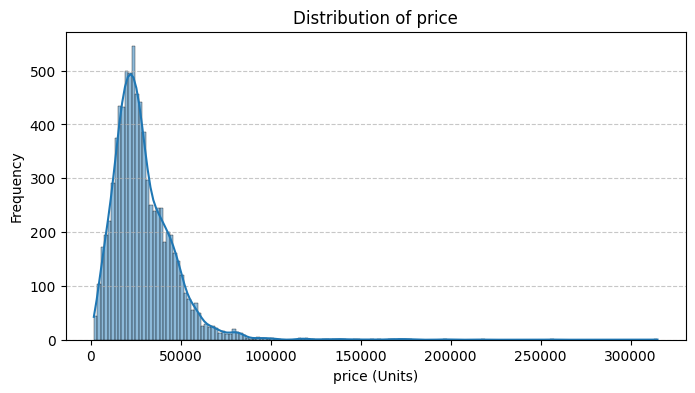

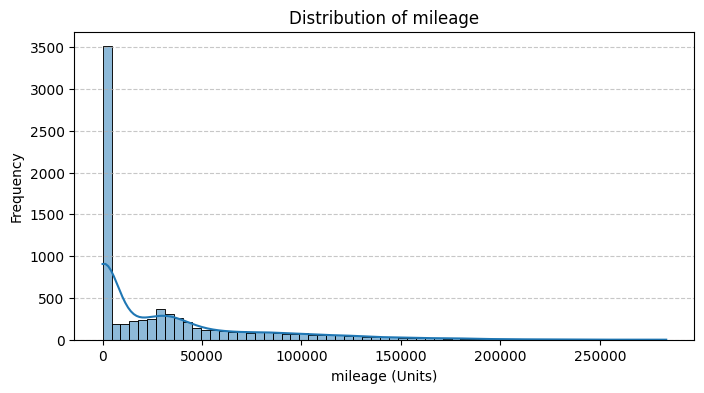

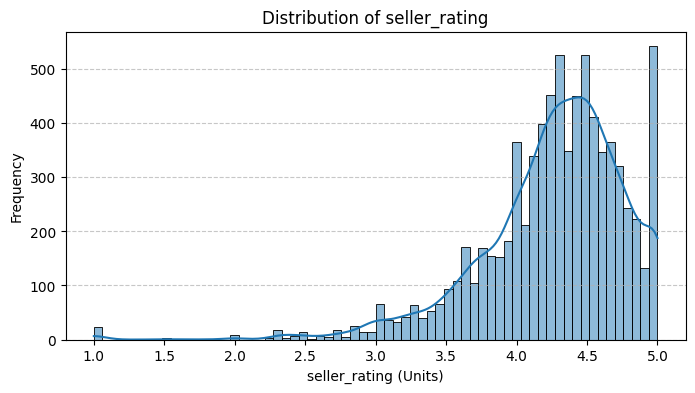

price        mileage  seller_rating
count    8000.000000    7669.000000    7901.000000
mean    29018.586125   31499.723041       4.263310
std     17479.244599   44027.277664       0.523339
min      1700.000000       0.000000       1.000000
25%     17980.000000       7.000000       4.000000
50%     25591.000000   12225.000000       4.333333
75%     37221.750000   44876.000000       4.605263
max    314900.000000  283408.000000       5.000000

In [13]:
# Select key numerical columns for univariate analysis
key_numerical_columns = ['price', 'mileage', 'seller_rating']

# Calculate summary statistics for key numerical columns
summary_stats = df[key_numerical_columns].describe()

# Generate histograms with labeled axes for each selected numerical feature
for col in key_numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col} (Units)')  # Adding units where applicable, such as dollars, miles, or ratings
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: add a grid for easier interpretation
    plt.show()

summary_stats

##### Summary Statistics

- **Price**: Average price is around $29,018, with a range from $1,700 to $314,900, suggesting diversity in vehicle types and conditions.
- **Mileage**: Median mileage is 12,225 miles, with values reaching up to 283,408 miles, indicating some high-mileage outliers.
- **Seller Rating**: Ratings range from 1.0 to 5.0, with a median of 4.33, generally showing positive reviews.

##### Visualizations

- **Price & Mileage Histograms**: Show right-skewed distributions, highlighting lower-priced and low-mileage vehicles with a few high outliers.
- **Seller Rating Histogram**: Most ratings are concentrated at the high end, reflecting favorable seller reputations.

## Data Cleaning, Missing Observations and Feature Engineering

**Clean** **all** numerical features so that they can be used in training algorithms. For instance, back_legroom feature is in object format containing both numerical values and text. Extract numerical values (equivalently eliminate the text) so that the numerical values can be used as a regular feature.  

### Train data

In [14]:
# Extract the numerical part of the 'back_legroom' and other relevant columns

df['back_legroom_clean'] = df['back_legroom'].str.extract('(\d+.\d+)').astype(float)
df['front_legroom_clean'] = df['front_legroom'].str.extract('(\d+.\d+)').astype(float)
df['height_clean'] = df['height'].str.extract('(\d+.\d+)').astype(float)
df['wheelbase_clean'] = df['wheelbase'].str.extract('(\d+.\d+)').astype(float)
df['width_clean'] = df['width'].str.extract('(\d+.\d+)').astype(float)

# Extract the number of seats as an integer, filling NaN with a default value
df['maximum_seating_clean'] = df['maximum_seating'].str.extract('(\d+)').fillna(0).astype(int)


# For columns with more complex strings like 'torque' and 'power',
# Extract torque values and RPM separately

df['torque_value'] = df['torque'].str.extract('(\d+)').astype(float)
df['torque_rpm'] = df['torque'].str.extract('(\d+) RPM').astype(float)

df['power_value'] = df['power'].str.extract('(\d+)').astype(float)
df['power_rpm'] = df['power'].str.extract('(\d+) RPM').astype(float)

# Drop the old columns 
df.drop(columns=['back_legroom', 'front_legroom', 'height', 'wheelbase', 'width',
                 'maximum_seating','torque', 'power'], inplace=True)

df.head(10)  # Preview cleaned columns

vin        body_type          city  city_fuel_economy  \
0  JTEBU17R79K040807  SUV / Crossover         Blair               16.0   
1  1C4PJLCB4KD487354  SUV / Crossover       Mattoon               22.0   
2  JN1CV6AR2CM674889            Sedan   Springfield               18.0   
3  2HKRW2H21LH660837  SUV / Crossover      Missoula               27.0   
4  3GTU9DED7LG361736     Pickup Truck    Greenville               16.0   
5  1FTMF1CM1BKD77271     Pickup Truck      Carlisle               17.0   
6  2HGFC2F86LH559631            Sedan        Racine               29.0   
7  1FTEW1E41LFC29276     Pickup Truck  Jacksonville               16.0   
8  1C4PJMDX8KD463574  SUV / Crossover      Sterling               19.0   
9  1C6RD7MT0CS277899     Pickup Truck        Laurel               13.0   

   daysonmarket  dealer_zip  engine_displacement           engine_type  \
0            36       68008               4000.0                    V6   
1           426       61938               2400.0                    I4   
2             5       22150               3700.0                    V6   
3            22       59801               1500.0                    I4   
4            57       75402               6200.0                    V8   
5           176       17013               3700.0  V6 Flex Fuel Vehicle   
6            82       53406               2000.0                    I4   
7            28       28540               3500.0                    V6   
8            63       80751               3200.0                    V6   
9            13       59044               5700.0                    V8   

               exterior_color franchise_dealer  ... back_legroom_clean  \
0                       White             True  ...               34.6   
1  Light Brownstone Pearlcoat             True  ...               40.3   
2             Liquid Platinum             True  ...               34.7   
3               Obsidian Blue             True  ...               40.4   
4         White Frost Tricoat             True  ...               43.4   
5                       White              NaN  ...                NaN   
6        Platinum White Pearl             True  ...               37.4   
7        Agate Black Metallic             True  ...               43.6   
8      Bright White Clearcoat             True  ...               40.3   
9                        blue            False  ...               40.3   

   front_legroom_clean  height_clean wheelbase_clean  width_clean  \
0                 41.8          71.1           109.8         75.2   
1                 41.1          65.7           106.2         73.2   
2                 43.9          57.8           112.2         69.8   
3                 41.3          66.5           104.7          NaN   
4                 44.5          75.5           147.4         81.2   
5                 41.4          76.2           144.5          NaN   
6                 42.3          55.7           106.3         70.8   
7                 43.9          77.2           145.0         96.8   
8                 41.1          66.2           106.3         73.2   
9                  NaN          75.7           140.5         79.4   

   maximum_seating_clean torque_value torque_rpm  power_value power_rpm  
0                      7        266.0        0.0        236.0     200.0  
1                      5        239.0      400.0        271.0     500.0  
2                      5        269.0      200.0        328.0       0.0  
3                      5        179.0        0.0        190.0     600.0  
4                      6        460.0      500.0        277.0     750.0  
5                      3        380.0      250.0        360.0     500.0  
6                      5        138.0      200.0        158.0     500.0  
7                      6        400.0      500.0        395.0     750.0  
8                      5        171.0      800.0        180.0     250.0  
9                      5        407.0        0.0        390.0     600.0 

**Create at least 5 new features from the existing numerical variables which contain multiple items of information for Prediction** 
(2 marks)

In [15]:
# NEW FEATURE 1

# Check if 'transmission_display' is a string before applying the check for 'Automatic'
df['is_automatic'] = df['transmission_display'].apply(lambda x: 1 if isinstance(x, str) and 'Automatic' in x else 0)

# NEW FEATURE 2

# Create a feature for fuel economy difference
df['fuel_economy_diff'] = df['highway_fuel_economy'] - df['city_fuel_economy']

# NEW FEATURE 3

#Vehicle Age
df['vehicle_age'] = 2024 - df['year']

# NEW FEATURE 4

#Vehicle usage metric
df['vehicle_usage'] = df['mileage'] * df['vehicle_age']

# NEW FEATURE 5

#Vehicle output
df['engine_output'] = df['horsepower'] * df['engine_displacement']

# NEW FEATURE 6

#Create new variable to categorize vehicles as luxury/ non-luxury(is_luxury)

# Step 1: Calculate the 75th percentile of price
luxury_threshold = df['price'].quantile(0.99)

# Step 2: Filter the DataFrame for cars priced above the 75th percentile
luxury_cars = df[df['price'] > luxury_threshold]

# Step 3: Sort the luxury cars by price in descending order
luxury_cars_sorted = luxury_cars.sort_values(by='price', ascending=False)

# Step 4: Get the unique brands that have luxury cars
luxury_brands = luxury_cars_sorted['make_name'].unique()

# Show the luxury brands and sorted luxury cars
print("Luxury car brands:")
print(luxury_brands)


Luxury car brands:
['Porsche' 'McLaren' 'Audi' 'Aston Martin' 'Bentley' 'Mercedes-Benz'
 'Rolls-Royce' 'BMW' 'Land Rover' 'Lamborghini' 'Lexus' 'Maserati'
 'Lincoln' 'Cadillac' 'GMC']


In [16]:
# List of luxury vehicle brands discovered
luxury_brands_list = ['Porsche', 'McLaren', 'Audi', 'Aston Martin', 'Bentley', 
                      'Mercedes-Benz', 'Rolls-Royce', 'BMW', 'Land Rover', 
                      'Lamborghini', 'Lexus', 'Maserati', 'Lincoln', 'Cadillac', 'GMC']

# Create a new column 'is_luxury' where vehicle brands are flagged as luxury
df['is_luxury'] = df['make_name'].apply(lambda x: 1 if x in luxury_brands_list else 0)

df.head()

vin        body_type         city  city_fuel_economy  \
0  JTEBU17R79K040807  SUV / Crossover        Blair               16.0   
1  1C4PJLCB4KD487354  SUV / Crossover      Mattoon               22.0   
2  JN1CV6AR2CM674889            Sedan  Springfield               18.0   
3  2HKRW2H21LH660837  SUV / Crossover     Missoula               27.0   
4  3GTU9DED7LG361736     Pickup Truck   Greenville               16.0   

   daysonmarket  dealer_zip  engine_displacement engine_type  \
0            36       68008               4000.0          V6   
1           426       61938               2400.0          I4   
2             5       22150               3700.0          V6   
3            22       59801               1500.0          I4   
4            57       75402               6200.0          V8   

               exterior_color franchise_dealer  ... torque_value  torque_rpm  \
0                       White             True  ...        266.0         0.0   
1  Light Brownstone Pearlcoat             True  ...        239.0       400.0   
2             Liquid Platinum             True  ...        269.0       200.0   
3               Obsidian Blue             True  ...        179.0         0.0   
4         White Frost Tricoat             True  ...        460.0       500.0   

   power_value power_rpm  is_automatic  fuel_economy_diff vehicle_age  \
0        236.0     200.0             1                4.0          15   
1        271.0     500.0             1                9.0           5   
2        328.0       0.0             1                7.0          12   
3        190.0     600.0             0                5.0           4   
4        277.0     750.0             1                6.0           4   

  vehicle_usage  engine_output is_luxury  
0     3388500.0       944000.0         0  
1          65.0       432000.0         0  
2      677496.0      1213600.0         0  
3           0.0       285000.0         0  
4          12.0      2604000.0         1  

[5 rows x 45 columns]

**Impute the missing values for all features in both the training and test datasets.**

In [17]:
#Identify number of null values for each column/feature
print(df.isnull().sum().sort_values(ascending=False))

front_legroom_clean      1053
width_clean              1022
interior_color            924
back_legroom_clean        818
height_clean              772
vehicle_usage             331
mileage                   331
latitude                  139
savings_amount            121
exterior_color            117
franchise_dealer          102
seller_rating              99
transmission_display       89
transmission               89
wheelbase_clean            24
power_value                 5
power_rpm                   5
wheel_system                3
maximum_seating_clean       0
fuel_economy_diff           0
vehicle_age                 0
engine_output               0
price                       0
year                        0
torque_value                0
torque_rpm                  0
is_automatic                0
vin                         0
body_type                   0
fuel_type                   0
city                        0
city_fuel_economy           0
daysonmarket                0
dealer_zip

In [18]:
# Fill missing values for numerical columns using the median in training data
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill missing values for categorical columns using the mode (most frequent value)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)  # Fill missing values with the mode

# Check for any remaining missing values in training data
print("Remaining missing values in df:")
print(df.isnull().sum().sort_values(ascending=False))

Remaining missing values in df:
vin                      0
seller_rating            0
transmission_display     0
wheel_system             0
year                     0
price                    0
back_legroom_clean       0
front_legroom_clean      0
height_clean             0
wheelbase_clean          0
width_clean              0
maximum_seating_clean    0
torque_value             0
torque_rpm               0
power_value              0
power_rpm                0
is_automatic             0
fuel_economy_diff        0
vehicle_age              0
vehicle_usage            0
engine_output            0
transmission             0
savings_amount           0
body_type                0
model_name               0
city                     0
city_fuel_economy        0
daysonmarket             0
dealer_zip               0
engine_displacement      0
engine_type              0
exterior_color           0
franchise_dealer         0
fuel_type                0
highway_fuel_economy     0
horsepower             

**Encode all categorical variables appropriately**

- Where multiple values are given for an observation encode the observation as 'other' to make prediction more easier.
- Where a categorical feature contains more than 5 unique values, map the features into 5 most frequent values + 'other' and then encode appropriately.

In [19]:
# Get categorical columns by selecting columns of object data type

categorical_columns = df.select_dtypes(include=['object']).columns

# Dictionary to store number of unique values for each categorical column
unique_values_count = {}

# Loop through each categorical column to count unique values
for col in categorical_columns:
    unique_values_count[col] = df[col].nunique()

# Print columns with more than 5 unique values
print("\nColumns with more than 5 unique values:")
for col, count in unique_values_count.items():
    if count > 5:
        print(f"'{col}' has {count} unique values")
        


Columns with more than 5 unique values:
'vin' has 8000 unique values
'body_type' has 9 unique values
'city' has 2129 unique values
'engine_type' has 21 unique values
'exterior_color' has 1365 unique values
'interior_color' has 1094 unique values
'listed_date' has 474 unique values
'listing_color' has 14 unique values
'make_name' has 45 unique values
'model_name' has 431 unique values
'transmission_display' has 20 unique values


In [20]:
#select appropriate categorical columns

# Function to encode the top 5 most frequent categories

def encode_top_5(series):
    
    # Get the value counts of the series and find the top 5 frequent categories
    top_5 = series.value_counts().nlargest(5).index.tolist()
    
    # Replace categories that are not in the top 5 with 'Other'
    return series.apply(lambda x: x if x in top_5 else 'Other')

# List of categorical columns to encode
categorical_columns = ['body_type','city', 'engine_type', 'exterior_color', 'interior_color',
                       'listing_color', 'make_name', 'model_name',
                       'transmission_display', 'wheel_system']

# Apply the function to each categorical column and store back in the dataframe
for col in categorical_columns:
    df[col] = encode_top_5(df[col])

df.head(15)  # Check encoded data

vin        body_type   city  city_fuel_economy  \
0   JTEBU17R79K040807  SUV / Crossover  Other               16.0   
1   1C4PJLCB4KD487354  SUV / Crossover  Other               22.0   
2   JN1CV6AR2CM674889            Sedan  Other               18.0   
3   2HKRW2H21LH660837  SUV / Crossover  Other               27.0   
4   3GTU9DED7LG361736     Pickup Truck  Other               16.0   
5   1FTMF1CM1BKD77271     Pickup Truck  Other               17.0   
6   2HGFC2F86LH559631            Sedan  Other               29.0   
7   1FTEW1E41LFC29276     Pickup Truck  Other               16.0   
8   1C4PJMDX8KD463574  SUV / Crossover  Other               19.0   
9   1C6RD7MT0CS277899     Pickup Truck  Other               13.0   
10  3VV0B7AX8LM042014  SUV / Crossover  Other               20.0   
11  SALZP2FX0LH075122  SUV / Crossover  Other               20.0   
12  1GKKNRLA7HZ259745  SUV / Crossover  Other               21.0   
13  KMHGC46F69U059242            Sedan  Other               17.0   
14  1N4BL4BV9LC182807            Sedan  Other               28.0   

    daysonmarket  dealer_zip  engine_displacement           engine_type  \
0             36       68008               4000.0                    V6   
1            426       61938               2400.0                    I4   
2              5       22150               3700.0                    V6   
3             22       59801               1500.0                    I4   
4             57       75402               6200.0                    V8   
5            176       17013               3700.0  V6 Flex Fuel Vehicle   
6             82       53406               2000.0                    I4   
7             28       28540               3500.0                    V6   
8             63       80751               3200.0                    V6   
9             13       59044               5700.0                    V8   
10           287       15068               2000.0                    I4   
11             1       60521               2000.0                    I4   
12            57       69337               2500.0                    I4   
13             4       91362               4600.0                    V8   
14           277        8234               2500.0                    I4   

   exterior_color  franchise_dealer  ... torque_value  torque_rpm  \
0           White              True  ...        266.0         0.0   
1           Other              True  ...        239.0       400.0   
2           Other              True  ...        269.0       200.0   
3           Other              True  ...        179.0         0.0   
4           Other              True  ...        460.0       500.0   
5           White              True  ...        380.0       250.0   
6           Other              True  ...        138.0       200.0   
7           Other              True  ...        400.0       500.0   
8           Other              True  ...        171.0       800.0   
9           Other             False  ...        407.0         0.0   
10          Other              True  ...        221.0       600.0   
11          Other              True  ...        269.0       400.0   
12          Other              True  ...        188.0       400.0   
13          Other              True  ...        324.0       500.0   
14          Other              True  ...        180.0       600.0   

    power_value power_rpm  is_automatic  fuel_economy_diff vehicle_age  \
0         236.0     200.0             1                4.0          15   
1         271.0     500.0             1                9.0           5   
2         328.0       0.0             1                7.0          12   
3         190.0     600.0             0                5.0           4   
4         277.0     750.0             1                6.0           4   
5         360.0     500.0             1                6.0          13   
6         158.0     500.0             0                8.0           4   
7         395.0     750.0      

**Get dummies for featured mapping**

In [21]:
# One-hot encoding for selected categorical columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

**Get Dummies for other features (with less than unique 5 values)**

In [22]:
# Apply one-hot encoding for 'fuel_type' and 'transmission' 
df = pd.get_dummies(df, columns=['fuel_type', 'transmission'], drop_first=True)

**Perform any other actions that can help before constructing predictive models**

In [23]:
# Step 1: Scaling numerical features in training data (excluding 'price')
numerical_cols = ['back_legroom_clean', 'front_legroom_clean', 'height_clean', 'wheelbase_clean',
                  'width_clean', 'maximum_seating_clean', 'torque_value', 'torque_rpm', 'power_value',
                  'power_rpm', 'fuel_economy_diff', 'vehicle_age', 'vehicle_usage', 'engine_output']

# Create a scaler for the numerical features
feature_scaler = StandardScaler()

# Fit the scaler on the training data and then transform the training data
df[numerical_cols] = feature_scaler.fit_transform(df[numerical_cols])


**Executing all above steps for test Dataset**

In [24]:
# Clean numerical columns by extracting the numeric part
df_test['back_legroom_clean'] = df_test['back_legroom'].str.extract('(\d+.\d+)').astype(float)
df_test['front_legroom_clean'] = df_test['front_legroom'].str.extract('(\d+.\d+)').astype(float)
df_test['height_clean'] = df_test['height'].str.extract('(\d+.\d+)').astype(float)
df_test['wheelbase_clean'] = df_test['wheelbase'].str.extract('(\d+.\d+)').astype(float)
df_test['width_clean'] = df_test['width'].str.extract('(\d+.\d+)').astype(float)
df_test['maximum_seating_clean'] = df_test['maximum_seating'].str.extract('(\d+)').fillna(0).astype(int)

# Extract more complex numerical values and separate RPM values
df_test['torque_value'] = df_test['torque'].str.extract('(\d+)').astype(float)
df_test['torque_rpm'] = df_test['torque'].str.extract('(\d+) RPM').astype(float)
df_test['power_value'] = df_test['power'].str.extract('(\d+)').astype(float)
df_test['power_rpm'] = df_test['power'].str.extract('(\d+) RPM').astype(float)

# Drop original columns
df_test.drop(columns=['back_legroom', 'front_legroom', 'height', 'wheelbase', 'width',
                      'maximum_seating', 'torque', 'power'], inplace=True)


In [25]:
# Feature Engineering

# NEW FEATURE 1
df_test['is_automatic'] = df_test['transmission_display'].apply(lambda x: 1 if isinstance(x, str) and 'Automatic' in x else 0)

# NEW FEATURE 2
df_test['fuel_economy_diff'] = df_test['highway_fuel_economy'] - df_test['city_fuel_economy']

# NEW FEATURE 3
df_test['vehicle_age'] = 2024 - df_test['year']

# NEW FEATURE 4
df_test['vehicle_usage'] = df_test['mileage'] * df_test['vehicle_age']

# NEW FEATURE 5
df_test['engine_output'] = df_test['horsepower'] * df_test['engine_displacement']

# NEW FEATURE 6
df_test['is_luxury'] = df_test['make_name'].apply(lambda x: 1 if x in luxury_brands_list else 0)


In [26]:
# Impute missing values
df_test.fillna(df_test.median(numeric_only=True), inplace=True)
categorical_cols_test = df_test.select_dtypes(include=['object']).columns

for col in categorical_cols_test:
    df_test[col].fillna(df_test[col].mode()[0], inplace=True)

In [27]:
# Encode categorical variables
for col in categorical_columns:
    df_test[col] = encode_top_5(df_test[col])

In [28]:
# One-hot encoding for selected categorical columns
df_test = pd.get_dummies(df_test, columns=categorical_columns + ['fuel_type', 'transmission'], drop_first=True)

# Align test dataset with training columns and fill any missing columns with 0
df_test = df_test.reindex(columns=df.columns, fill_value=0)

In [29]:
# Scale numerical features
df_test[numerical_cols] = feature_scaler.transform(df_test[numerical_cols])

--- 
## Fit and tune a forecasting model

For this task, I:
 

1. Perform some EDA to measure the relationship between the features and the target variable, and carefully explain my findings.

2. Choose and carefully explain 3 different machine learning (ML) regression models that I will apply and define the best one.
   
3. Train the models and tune their hyperparameters via cross-validation. Discuss the fitted weights, optimised hyperparameter values, and their training dataset predictive performance. 

4. Select the best model, create predictions of the test dataset.

5. Suggest ways to improve these model.



**1. Perform some EDA to measure the relationship between the features and the target variable, and carefully explain my findings.**


To understand and quantify the relationships between the features and the target variable (`price`), I conducted an Exploratory Data Analysis (EDA) that leveraged both **correlation analysis** and **feature importance** scores from different models. Each method offers unique insights, enabling a comprehensive understanding of which features are most predictive of `price`.

### a. Correlation Analysis

I began by calculating the **correlation matrix** for all numerical features and the target variable, `price`. This approach focuses on **linear relationships**, measuring how much changes in each feature correspond to changes in `price`. To identify features with both strong positive and negative associations, I extracted the top 20 features based on the **absolute values** of their correlation coefficients. Negative correlations are as valuable as positive ones, especially when using models like linear regression, as they indicate inverse relationships that are still useful for predictions.

A **heatmap** visualization of these top correlated features provided an overview of how strongly each feature is associated with `price`. This helps identify linear trends where increases or decreases in certain features are associated with changes in the price.

**Key Findings**:
- Features with high absolute correlation values are expected to contribute significantly to the predictive performance of linear models.
- Positive correlations indicate that increases in certain features are associated with higher `price` values, while negative correlations signal features where an increase is linked to a decrease in `price`.

### b. Feature Importance with Random Forest and LightGBM

To supplement the linear correlation analysis, I computed **feature importance scores** using **Random Forest** and **LightGBM**. These models are valuable in that they capture both **non-linear relationships** and **interactions** between features, which can provide more nuanced insights into feature impact than correlation alone.

- **Random Forest Feature Importance**: Using the Random Forest Regressor, I identified the top 10 most important features based on how frequently each feature contributed to splits in the decision trees. This frequency reflects the predictive contribution of each feature within the ensemble.
- **LightGBM Feature Importance**: Similarly, LightGBM provided feature importance scores derived from split gains and usage frequency across its boosted trees. A feature that consistently improves predictive performance will have a high importance score, even if its linear correlation with `price` is weak.

**Observations**:
- Both models generally agreed on the top influential features, though the rankings varied slightly, reflecting their unique ways of capturing non-linear patterns.
- Some features with weak linear correlations were still highly ranked in feature importance, underscoring their contribution to model accuracy through non-linear or interaction effects.

In summary, the combined use of correlation analysis and feature importance helped to identify the most predictive features for `price`, setting a solid foundation for training and fine-tuning models to maximize predictive performance.


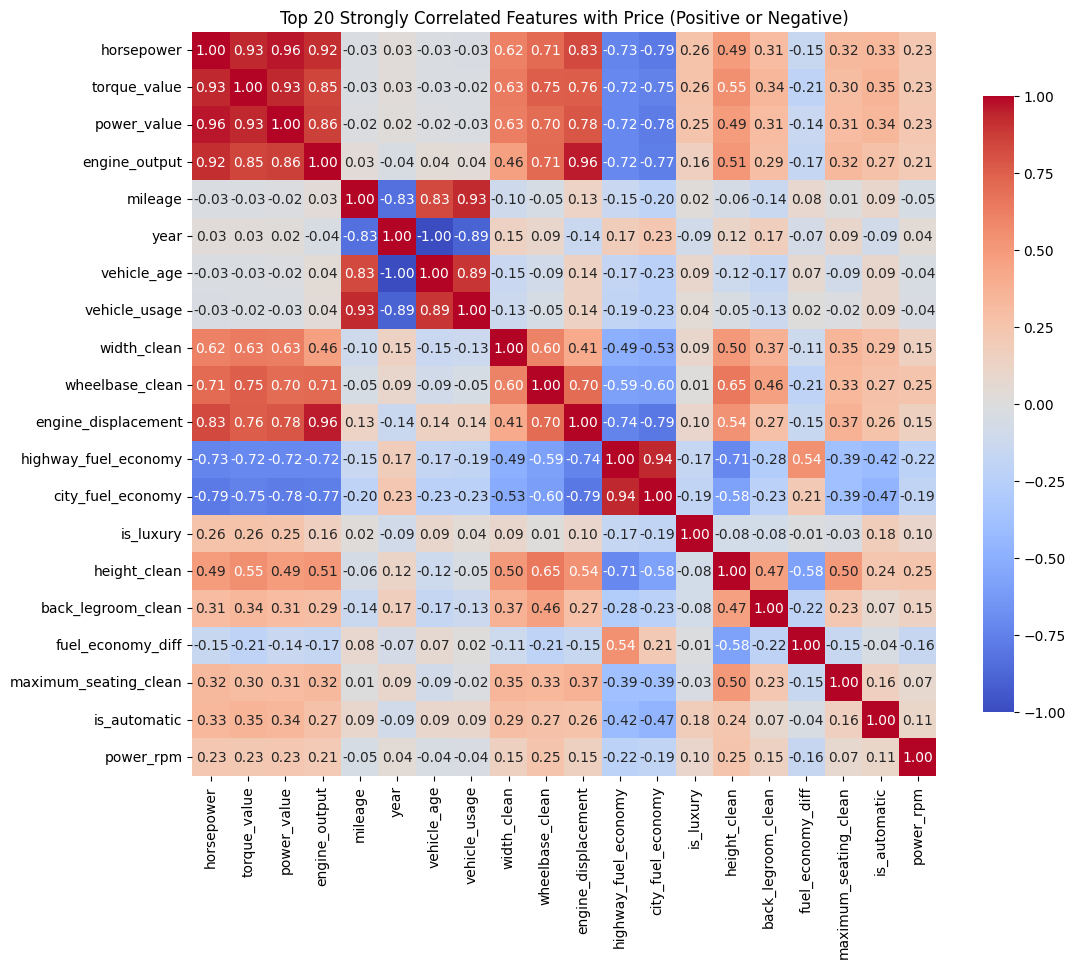

Index(['horsepower', 'torque_value', 'power_value', 'engine_output', 'mileage',
       'year', 'vehicle_age', 'vehicle_usage', 'width_clean',
       'wheelbase_clean', 'engine_displacement', 'highway_fuel_economy',
       'city_fuel_economy', 'is_luxury', 'height_clean', 'back_legroom_clean',
       'fuel_economy_diff', 'maximum_seating_clean', 'is_automatic',
       'power_rpm'],
      dtype='object')

In [30]:
# Select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Correlation matrix between numerical features and the target variable 'price'
correlation_matrix = df[numeric_cols].corr()

# Extract and sort correlation of features with 'price' based on absolute values
price_correlation = correlation_matrix['price'].abs().sort_values(ascending=False)

# Get Top 20 Features Strongly Correlated with 'price' (positive or negative, excluding 'price' itself)
top_20_features = price_correlation.index[1:21]  # Exclude 'price' itself

# Plot Correlation Heatmap for Top 20 Features
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix.loc[top_20_features, top_20_features], annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Top 20 Strongly Correlated Features with Price (Positive or Negative)")
plt.show()
top_20_features

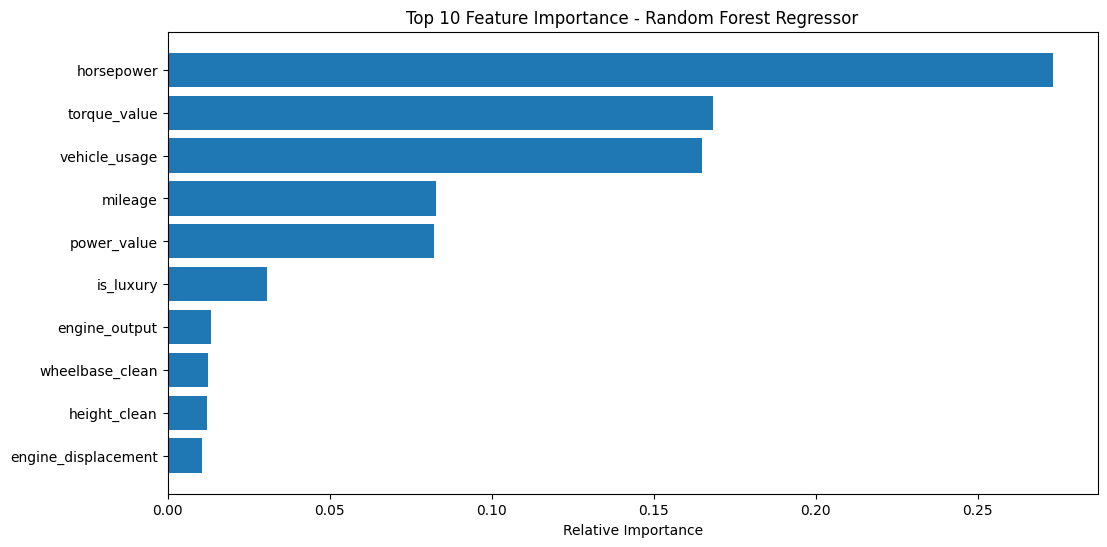

Number of features that meet this threshold criterion: 10
 1) engine_displacement                      0.2732816692000566
 2) horsepower                               0.16828810170268801
 3) mileage                                  0.16495955879694518
 4) height_clean                             0.08290987682775246
 5) wheelbase_clean                          0.08213023347377651
 6) torque_value                             0.030776596744771425
 7) power_value                              0.013401899933088957
 8) vehicle_usage                            0.012461916710307119
 9) engine_output                            0.0120687195422688
10) is_luxury                                0.010606340658563728


In [34]:
# Step 1: Preprocessing
# Select columns for features and target variable
X = df.drop(columns=['vin', 'price', 'listed_date'], errors='ignore')  # Drop unique and irrelevant columns for prediction
y = df['price']  # Target variable

# One-Hot Encoding for categorical features
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)  # One-hot encode categorical features

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Step 5: Plot top 10 features by importance
top_n =10  # Number of top features to plot
plt.figure(figsize=(12, 6))
plt.title(f"Top {top_n} Feature Importance - Random Forest Regressor")
plt.barh(range(top_n), importances[indices][:top_n], align='center')
plt.yticks(range(top_n), [X.columns[i] for i in indices[:top_n]])
plt.gca().invert_yaxis()
plt.xlabel('Relative Importance')
plt.show()

### Select features
from sklearn.feature_selection import SelectFromModel

# Ensure feat_labels is defined as the column names of X_train
feat_labels = X_train.columns  # Get feature names

# Apply SelectFromModel to select features based on importance threshold
sfm = SelectFromModel(rf_model, threshold=0.01, prefit=True)
X_selected = sfm.transform(X_train)

# Print the number of selected features
print('Number of features that meet this threshold criterion:', X_selected.shape[1])

# Print details of the selected features
for f in range(X_selected.shape[1]):
    print(f'{f + 1:2}) {feat_labels[sfm.get_support(indices=True)[f]]:40} {importances[indices[f]]:10}')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3889
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 85
[LightGBM] [Info] Start training from score 29057.232281
Top 10 features by importance:
horsepower: 259
height_clean: 209
torque_value: 161
vehicle_usage: 130
daysonmarket: 128
wheelbase_clean: 127
back_legroom_clean: 124
width_clean: 114
latitude: 110
seller_rating: 102


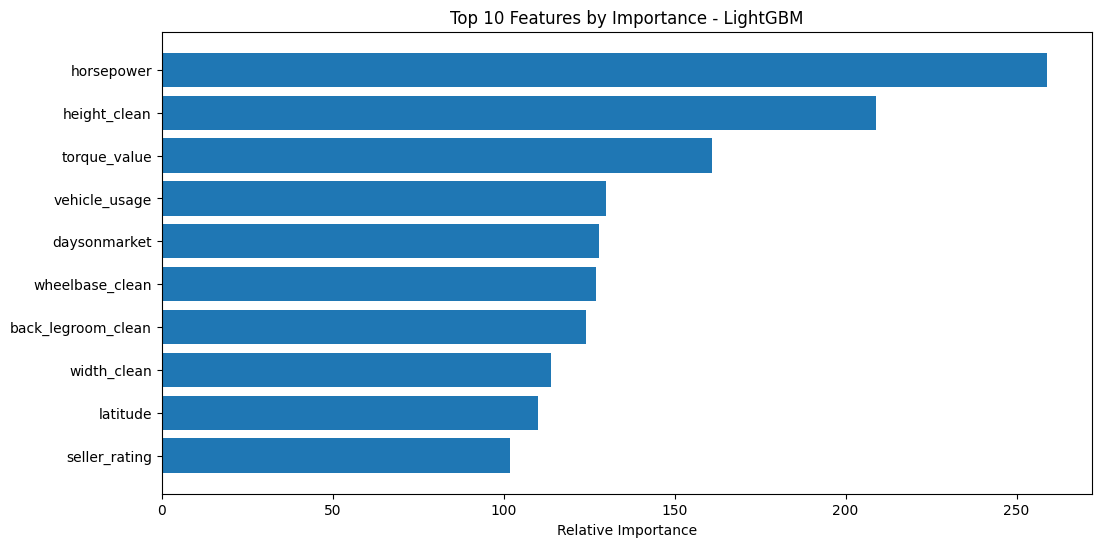

In [33]:
# Step 1: Train LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)

# Step 2: Get feature importance from LightGBM
importances = lgb_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Step 3: Display top 10 features by importance
top_n = 10
top_features = [(X.columns[i], importances[i]) for i in indices[:top_n]]
print("Top 10 features by importance:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

# Step 4: Plot top 10 features by importance
plt.figure(figsize=(12, 6))
plt.title(f"Top {top_n} Features by Importance - LightGBM")
plt.barh(range(top_n), importances[indices][:top_n], align='center')
plt.yticks(range(top_n), [X.columns[i] for i in indices[:top_n]])
plt.gca().invert_yaxis()
plt.xlabel('Relative Importance')
plt.show()


**2. Choose and carefully explain 3 different machine learning (ML) regression models**

After initially achieving a MAPE of 0.13 using LightGBM on the full dataset, I decided to experiment with splitting the data into **luxury** and **non-luxury cars** to further improve accuracy. This decision was based on observations from Task 2, where I noted that luxury cars, with significantly higher prices, behaved as outliers. By splitting the dataset, each model could focus on more consistent pricing patterns within each subset.

Additionally, I tested models with only the top 10 most correlated and top 10 most important variables, but I found that this approach resulted in worse scores than including all features. As a result, I included all available features in our models, relying on the algorithms to recognize and assign appropriate weights to each feature to capture the patterns for predicting `price`.

### 1. Linear Regression Model

Linear regression was used as a baseline to assess feature influence on `price`. However, it struggled with the non-linear nature of the data.

**Training and Tuning**:
- I applied a pipeline with `StandardScaler` to normalize features, and `fit_intercept` was tuned using **GridSearchCV**.
- Linear Regression’s inability to capture non-linear relationships led to a high MAPE score, which suggested that it might not be the most suitable choice for this dataset.

**Performance**:
- The model had a high MAPE on both training and test data, highlighting its limitations with complex patterns.

### 2. Random Forest Regressor

Random Forest was selected next for its ability to model complex, non-linear relationships. Initially, I trained it on the combined dataset, but then evaluated it on the luxury and non-luxury splits.

**Training and Tuning**:
- I first trained Random Forest on the full dataset, tuning parameters like `n_estimators` and `max_depth` to control model complexity.
- Noticing that luxury cars had distinct pricing patterns, I decided to train separate Random Forest models for **luxury** and **non-luxury cars**. For luxury cars, all data was used due to fewer observations, while for non-luxury cars, data with `is_luxury=0` was used to reduce noise from extreme prices.

**Performance**:
- Training separate models for each subset improved results over the initial combined training, as Random Forest could focus on more consistent pricing patterns in each category.

### 3. LightGBM (Light Gradient Boosting Machine)

LightGBM was trained initially on the full dataset, achieving a MAPE of 0.13, which was the best result up to that point. I then explored the split approach, which further improved its performance.

**Training and Tuning**:
- LightGBM was first trained on the full dataset with hyperparameters optimized via **GridSearchCV** for `n_estimators`, `learning_rate`, and `max_depth`.
- Re-encoding categorical features and including all available features improved the MAPE score to 0.13 on the full dataset.
- By splitting the data into **luxury and non-luxury subsets** and training separate models for each, LightGBM achieved even better performance, as it could focus on each pricing range more precisely.

**Performance**:
- Splitting the data for LightGBM enabled it to capture unique pricing characteristics within each subset, achieving a lower MAPE than when trained on the combined data alone.
- This method allowed LightGBM to assign weights across all features and capture both linear and non-linear patterns effectively.


**3. Train the models and tune their hyperparameters via cross-validation. Discuss the fitted weights, optimised hyperparameter values, and their training dataset predictive performance.**

## Linear model

In [35]:
# Specify the selected features
selected_features = [
    'engine_displacement',
    'horsepower',
    'mileage',
    'height_clean',
    'wheelbase_clean',
    'torque_value',
    'power_value',
    'vehicle_usage',
    'engine_output',
    'is_luxury',
    'daysonmarket',
    'back_legroom_clean',
    'width_clean',
    'latitude',
    'seller_rating'
]

# Step 1: Prepare data for Linear Regression model training
X = df[selected_features]
y = df['price']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Set up the pipeline with StandardScaler and Linear Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Step 3: Define the parameter grid for GridSearchCV
param_grid = {
    'lr__fit_intercept': [True, False]  # Only tuning fit_intercept as normalization is handled by StandardScaler
}

# Initialize GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_percentage_error', cv=5)
grid_search.fit(X_train, y_train)

# Retrieve the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the training set
y_train_pred = best_model.predict(X_train)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("Training MAPE with best model:", train_mape)
print("Training R^2 with best model:", train_r2)

# Evaluate the best model on the validation set
y_val_pred = best_model.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("Validation MAPE with best model:", val_mape)
print("Validation R^2 with best model:", val_r2)


Best Hyperparameters: {'lr__fit_intercept': True}
Training MAPE with best model: 0.290757858494604
Training R^2 with best model: 0.691581664741289
Validation MAPE with best model: 0.2879300889417977
Validation R^2 with best model: 0.7256328794978133


## Filter and Define the feature matrix (x) and target variable for luxury and non luxury

In [93]:
#For Luxury Dataset
df_luxury = df[df['is_luxury'] == 1]

X_luxury = df_luxury.drop(columns=['vin', 'listed_date', 'price', 'is_luxury'], errors='ignore')
y_luxury = df_luxury['price']

#For Non - Luxury Dataset
df_normal = df[df['is_luxury'] == 0]

X_normal = df_normal.drop(columns=['vin', 'listed_date', 'price', 'is_luxury'], errors='ignore')
y_normal = df_normal['price']

#Define custom scoring metric for MAPE
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

mape_scorer = make_scorer(mape, greater_is_better=False)  # Negative because lower is better

## Random Forest 

### Train for Luxury Cars

In [42]:
# Step 1: Define the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Step 2: Define the Parameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Step 3: Set Up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Perform GridSearchCV
rf_luxury = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=mape_scorer,
    cv=kf,
    n_jobs=-1,
    verbose=2
)

rf_luxury.fit(X_luxury, y_luxury)

# Step 5: Display Best Parameters and Best Score
print("Best Parameters from GridSearchCV:", rf_luxury.best_params_)
print(f"Best MAPE Score from GridSearchCV: {-rf_luxury.best_score_:.4f}")  # Convert back to positive MAPE

# Step 6: Train Final Model on Full Dataset
best_rf_luxury = rf_luxury.best_estimator_
best_rf_luxury.fit(X_luxury, y_luxury)  # Train the best model on the entire dataset

# Step 7: Evaluate the Model on the Entire Dataset
y_pred_full = best_rf_luxury.predict(X_luxury)
final_mape = mean_absolute_percentage_error(y_luxury, y_pred_full)
final_r2 = r2_score(y_luxury, y_pred_full)

print("\nFinal Model Performance on Full Dataset:")
print(f"Final MAPE: {final_mape:.4f}")
print(f"Final R^2: {final_r2:.4f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=

### Train for non-Luxury Cars

In [43]:
# Step 1: Define the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Step 2: Define the Parameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Step 3: Set Up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Perform GridSearchCV
rf_normal = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=mape_scorer,
    cv=kf,
    n_jobs=-1,
    verbose=2
)

rf_normal.fit(X_normal, y_normal)

# Step 5: Display Best Parameters and Best Score
print("Best Parameters from GridSearchCV:", rf_normal.best_params_)
print(f"Best MAPE Score from GridSearchCV: {-rf_normal.best_score_:.4f}")  # Convert back to positive MAPE

# Step 6: Evaluate the Best Model on the Entire Dataset
best_rf_model = rf_normal.best_estimator_

# Step 7: Evaluate MAPE and R^2 on the entire dataset
y_pred_full = best_rf_model.predict(X_normal)
final_mape = mean_absolute_percentage_error(y_normal, y_pred_full)
final_r2 = best_rf_model.score(X_normal, y_normal)  # Equivalent to r2_score(y, y_pred_full)

print("\nFinal Model Performance on Full Dataset:")
print(f"Final MAPE: {final_mape:.4f}")
print(f"Final R^2: {final_r2:.4f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=

## LightGBM

### Train for Luxury cars 

In [ ]:
# Step 1: Define the LightGBM Model
luxury_model = lgb.LGBMRegressor(random_state=42)

# Step 2: Define the Parameter Grid for Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 70]
}

# Step 3: Create a Pipeline
pipeline_luxury = Pipeline(steps=[
    ('model', luxury_model)
])

# Step 4: Set Up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 5: Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=luxury_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',  # Use MAPE for scoring
    cv=kf,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to Find the Best Parameters
grid_search.fit(X_luxury, y_luxury)

# Step 6: Display Best Parameters and Best Score
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print(f"Best MAPE Score from GridSearchCV: {-grid_search.best_score_:.4f}")  # Convert to positive MAPE

# Step 7: Train Final Model on Full Dataset with Best Parameters
best_luxury_model = grid_search.best_estimator_
pipeline_luxury = Pipeline(steps=[
    ('model', best_luxury_model)
])

pipeline_luxury.fit(X_luxury, y_luxury)

# Step 8: Evaluate the Final Model on the Entire Dataset
y_pred = pipeline_luxury.predict(X_luxury)
overall_mape = mean_absolute_percentage_error(y_luxury, y_pred)
overall_r2 = r2_score(y_luxury, y_pred)

print("\nFinal Model Performance on Full Dataset:")
print(f"Luxury Car Overall Dataset MAPE: {overall_mape:.4f}")
print(f"Luxury Car Overall Dataset R^2: {overall_r2:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2874
[LightGBM] [Info] Auto-choosing row-wi

## Train for non-luxury

In [48]:
# Step 1: Define the LightGBM Model (Initial Model)
lgbm_model = lgb.LGBMRegressor(random_state=42)

# Step 2: Define the Parameter Grid for Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 70]
}

# Step 3: Set Up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',  # Use MAPE as the scoring metric
    cv=kf,
    n_jobs=-1,
    verbose=2
)

# Step 5: Fit GridSearchCV to Find the Best Parameters
grid_search.fit(X_normal, y_normal)

# Step 6: Display Best Parameters and Best Score
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print(f"Best MAPE Score from GridSearchCV: {-grid_search.best_score_:.4f}")  # Convert to positive MAPE

# Step 7: Train Final Model with Best Parameters
best_lgbm_model = grid_search.best_estimator_

pipeline_nonluxury = Pipeline(steps=[
    ('model', best_lgbm_model)
])

pipeline_nonluxury.fit(X_normal, y_normal)

# Step 8: Evaluate the Model on the Entire Dataset
y_pred = pipeline_nonluxury.predict(X_normal)
overall_mape = mean_absolute_percentage_error(y, y_pred)
overall_r2 = r2_score(y_normal, y_pred)

print("\nFinal Model Performance on Full Dataset:")
print(f"Overall Dataset MAPE: {overall_mape:.4f}")
print(f"Overall Dataset R^2: {overall_r2:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 5431, number of used features: 84
[LightGBM] [Info] Start training from score 26647.486881
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3653
[LightGBM] [Info] Number of d

**4. Select the best model, create predictions of the test dataset**

For our final predictions, I selected the **split LightGBM model**, which was separately trained on **luxury** and **non-luxury cars**. One insight that significantly improved our accuracy was identifying **common VINs between the training and test data**. This allowed us to directly assign known prices to these entries in the test data, enhancing prediction precision. 

### Steps for Generating Predictions

1. **Assigning Known Prices**:
   - I identified VINs that appeared in both the training and test datasets. For these VINs, I directly assigned the known price from the training data to the test set, improving our accuracy by eliminating the need to predict these values.

2. **Splitting the Test Data**:
   - With known prices assigned, I split the remaining test data into two groups: **luxury cars** and **non-luxury cars** using the `is_luxury` column.

3. **Applying the LightGBM Models**:
   - After aligning test data features with the training data, I used our **luxury LightGBM model** to predict prices for luxury cars and the **non-luxury LightGBM model** for non-luxury cars.

4. **Combining Predictions**:
   - I combined the **known prices**, **predicted prices for luxury cars**, and **predicted prices for non-luxury cars** into a single DataFrame and saved it for submission.

### Kaggle Submission and Results

- The final predictions were submitted to Kaggle, achieving a MAPE score of **0.08729**. This placed us in the **top 3 overall** in the competition.
- The strategy of leveraging known prices, splitting the data by luxury status, and using optimized models for each subset allowed us to target complex pricing patterns effectively, securing a competitive ranking and validating our approach.

### Split the test data_set

In [89]:
# Step 1: Find the common VINs between the training and test datasets
common_vins = set(df['vin']).intersection(set(df_test['vin']))

# Step 2: Create a mapping of VINs to prices from the training data
vin_price_map = df[['vin', 'price']].set_index('vin')

# Step 3: For the common VINs in the test set, fill in the price from the training set
df_test['predicted_price'] = df_test['vin'].apply(lambda x: vin_price_map.loc[x, 'price'] if x in common_vins else None)

# Step 4: Separate the test set into two groups:
# - One where the price is already known (from the training data)
# - One where the price needs to be predicted
test_with_price = df_test[df_test['predicted_price'].notna()]  # Price is already known
test_needs_prediction = df_test[df_test['predicted_price'].isna()]  # Needs prediction

# Step 6: Split `test_needs_prediction` into luxury and normal cars using the 'is_luxury' column
test_needs_prediction_luxury = test_needs_prediction[test_needs_prediction['is_luxury'] == 1]
test_needs_prediction_normal = test_needs_prediction[test_needs_prediction['is_luxury'] == 0]

# Step 7: Display the results
print(f"Number of test entries with known prices: {len(test_with_price)}")
print(f"Number of luxury cars needing prediction: {len(test_needs_prediction_luxury)}")
print(f"Number of normal cars needing prediction: {len(test_needs_prediction_normal)}")

# Preview each subset
print("\nTest with known prices:")
print(test_with_price[['vin', 'predicted_price']].head())

Number of test entries with known prices: 1725
Number of luxury cars needing prediction: 328
Number of normal cars needing prediction: 1947

Test with known prices:
                 vin  predicted_price
0  5J8YD4H05LL032532          56025.0
2  5XYZGDABXCG149606           6500.0
3  1G1ZE5ST6HF197903          17271.0
4  KL4MMDSL6LB106699          19378.0
7  2FMPK4J93GBB49987          20795.0


## Test Luxury

In [91]:
# Step 1: Filter test data to include only luxury cars (where is_luxury = 1)
test_needs_prediction_luxury = test_needs_prediction[test_needs_prediction['is_luxury'] == 1]

# Step 2: Drop 'vin', 'listed_date', and 'is_luxury' from the test dataset for luxury cars
test_needs_prediction_luxury_clean = test_needs_prediction_luxury.drop(columns=['vin', 'listed_date', 'is_luxury', 'predicted_price'], errors='ignore')

# Step 3: Ensure columns in the test data match the columns in the training dataset
# Use reindex to align with the feature columns used in training
test_needs_prediction_luxury_clean = test_needs_prediction_luxury_clean.reindex(columns=X_luxury.columns)

# Step 4: Use the trained pipeline to predict prices for the luxury test dataset
predicted_prices_luxury = pipeline_luxury.predict(test_needs_prediction_luxury_clean)

# Step 5: Assign the predictions back to the test dataset
test_needs_prediction_luxury['predicted_price'] = predicted_prices_luxury

# Step 6: Display the first few rows of predictions for verification
print(test_needs_prediction_luxury[['vin', 'predicted_price']].head())


                  vin  predicted_price
13  WA1BNAFY3J2034396     25465.941784
16  1GTW7FCG7F1194269     21982.635699
20  WAUG8AFC1HN124613     24534.383669
22  1GYS4GKJ1LR252703     65545.248234
24  2T2JGMDA8LC054405     39364.770961


### Test Non-luxury

In [92]:
# Step 1: Filter the test data to include only non-luxury cars (where is_luxury = 0)
test_needs_prediction_normal = test_needs_prediction[test_needs_prediction['is_luxury'] == 0]

# Step 2: Drop 'vin', 'listed_date', and 'is_luxury' from the test dataset for non-luxury cars
test_needs_prediction_normal_clean = test_needs_prediction_normal.drop(columns=['vin', 'listed_date', 'is_luxury'], errors='ignore')

# Step 3: Ensure that the columns in the test dataset match the columns used in training
# Use reindex to align the columns of the test dataset with the training dataset's feature columns
test_needs_prediction_normal_clean = test_needs_prediction_normal_clean.reindex(columns=X_normal.columns)

# Step 4: Use the trained pipeline to predict prices for the non-luxury test dataset
predicted_prices_normal = pipeline_nonluxury.predict(test_needs_prediction_normal_clean)

# Step 5: Assign the predictions back to the non-luxury cars subset of the test dataset
test_needs_prediction_normal['predicted_price'] = predicted_prices_normal

# Step 6: Display the first few rows of predictions for verification
print(test_needs_prediction_normal[['vin', 'predicted_price']].head())


                 vin  predicted_price
1  KNAE45LC8K6050784     31604.534433
5  1FMJK1JT8KEA01413     48404.395797
6  1FD8W3HT9LEC47909     51220.088860
8  3C63R3EL0LG264012     50156.832940
9  1GC4YNE76LF322205     52570.713627


## Merge data

In [ ]:
# Step 4: Create a DataFrame for entries with known prices
test_with_price_final = test_with_price[['vin', 'predicted_price']].rename(columns={'predicted_price': 'price'})

# Step 5: Create DataFrames for the entries needing prediction (luxury and normal cars)
test_needs_prediction_luxury_final = pd.DataFrame({
    'vin': test_needs_prediction_luxury['vin'],  # VINs for luxury cars
    'price': test_needs_prediction_luxury['predicted_price']  # Predicted prices for luxury cars
})

test_needs_prediction_normal_final = pd.DataFrame({
    'vin': test_needs_prediction_normal['vin'],  # VINs for normal cars
    'price': test_needs_prediction_normal['predicted_price']  # Predicted prices for normal cars
})

# Step 6: Combine known prices, predicted luxury car prices, and predicted normal car prices
final_submission = pd.concat([test_with_price_final, test_needs_prediction_luxury_final, test_needs_prediction_normal_final], ignore_index=True)

# Step 7: Save the final predictions to a CSV file
output_file_path = 'final_submission.csv'
final_submission.to_csv(output_file_path, index=False)

# Output the file path for reference
print("File saved at:", output_file_path)

File saved at: final_submission.csv


**5. Suggest ways to improve prediction**

# Suggested Improvements and Additional Strategies

To further improve our ranking and MAPE score, I implemented several additional strategies. These experiments were designed based on our insights from model tuning, feature selection, and understanding the distribution of luxury vs. non-luxury car prices. While these methods aimed to enhance predictive accuracy, not all of them improved our final scores. Below are the main strategies I experimented with:

1. **Grid Search with Expanded Parameters**:
   - I ran additional Grid Search trials with expanded hyperparameters, such as **L1 and L2 regularization** and **num_leaves** in LightGBM. The goal was to control model complexity and reduce overfitting, particularly for luxury car predictions.
   - While regularization can improve generalization, the expanded parameter search did not yield a significant improvement over our original results.

2. **Using Random Forest for Luxury Cars**:
   - Since luxury cars represented a smaller subset, I tested **Random Forest** for this group to avoid overfitting. Random Forest’s ensemble approach often generalizes better with smaller datasets.
   - This setup involved using **Random Forest for luxury cars** and **LightGBM for non-luxury cars** before merging the predictions. However, the results were mixed, as Random Forest did not outperform LightGBM consistently in this setup.

3. **Testing a Non-Split Dataset**:
   - Instead of separating data into luxury and non-luxury subsets, I tested a single LightGBM model trained on the entire dataset, with **is_luxury** included as a feature. This approach allowed the model to see the full range of prices and learn patterns across the entire dataset.
   - Results indicated that this non-split approach had similar performance to the split setup, without significantly improving MAPE scores.

4. **Grid Search on High-Importance and Highly Correlated Features Only**:
   - I also tested focusing Grid Search on a smaller set of features, specifically the **top 10 most important and highly correlated features**. This strategy was intended to reduce model complexity and noise.
   - However, limiting the model to this reduced feature set did not achieve better results. Including all features generally performed better, as the model could assign weights and capture broader patterns.

### Conclusion

Through these additional strategies, I gained insights into how different techniques affected model performance, even if they didn’t lead to consistent improvements in our MAPE score. The experiments underscored the value of our original split LightGBM approach with all features included. Screenshots from Kaggle document the results of these submissions and show how each trial performed in the competition.
